# Лабораторна Робота № 7
## Передавальне навчання з великими мовними моделями


## Мета: набути навички використання та донавчання великих мовних моделей на базі сервісу HuggingFace для розв'язання NLP задач.

### Імпорт бібліотек та датасету

In [1]:
import pandas as pd
import numpy as np
import time
from transformers import AutoTokenizer, BertTokenizer, TFBertForSequenceClassification, DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import re
import nltk
from keras import models
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score
import seaborn as sns

In [2]:
df_train = pd.read_csv("lab06_train.txt", sep=";", header=None, names=['Text', 'Emotion'])
df_test = pd.read_csv("lab06_test.txt", sep=";", header=None, names=['Text', 'Emotion'])
df_val = pd.read_csv("lab06_val.txt", sep=";", header=None, names=['Text', 'Emotion'])

In [3]:
emotions = df_train['Emotion'].unique().tolist()

In [4]:
df_train['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

### Завантаження моделі, токенизатора та токенизація даних

In [5]:
model_name = "distilbert/distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(emotions))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [6]:
###################################################
def tokenize_text(text):
    return tokenizer(text,
                     padding='max_length',
                     truncation=True,
                     max_length=128)

tokenized_text_train = df_train['Text'].apply(tokenize_text)
tokenized_text_test = df_test['Text'].apply(tokenize_text)
tokenized_text_val = df_val['Text'].apply(tokenize_text)


In [7]:
######################################################
def extract_features(series):
    input_ids = np.array([item['input_ids'] for item in series])
    attention_mask = np.array([item['attention_mask'] for item in series])
    return {'input_ids': input_ids, 'attention_mask': attention_mask}

tokenized_train_np = extract_features(tokenized_text_train)
tokenized_test_np = extract_features(tokenized_text_test)
tokenized_val_np = extract_features(tokenized_text_val)

In [8]:
y_train = df_train['Emotion']
y_test = df_test['Emotion']
y_val = df_val['Emotion']

label_encoder = LabelEncoder()
label_encoder.fit(emotions)

y_train = tf.keras.utils.to_categorical(label_encoder.transform(y_train), num_classes=len(emotions))
y_test = tf.keras.utils.to_categorical(label_encoder.transform(y_test), num_classes=len(emotions))
y_val = tf.keras.utils.to_categorical(label_encoder.transform(y_val), num_classes=len(emotions))

In [9]:
emotions

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

In [10]:
df_train[:15]

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


In [11]:
y_train[:15]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [12]:
emotions = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

### Функції графіків

In [13]:
def plot_learning_curve(history, figsize=(10, 5)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    axs[0].plot(history.history['accuracy'], color='#b8113d')
    axs[0].plot(history.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(history.history['loss'], color='#b8113d')
    axs[1].plot(history.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [34]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=emotions, yticklabels=emotions)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

### Model fine-tuning

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices((tokenized_train_np, y_train)).shuffle(len(df_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((tokenized_test_np, y_test)).shuffle(len(df_test)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((tokenized_val_np, y_val)).shuffle(len(df_val)).batch(32)

In [22]:
model.compile(
    #optimizer = tf.keras.optimizers.AdamW(3e-4),
    optimizer = 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

start_time = time.time()

history = model.fit(
    train_ds,
    epochs = 5,
    batch_size = 16,
    validation_data = val_ds,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
)

end_time = time.time()

Epoch 1/5
500/500 [==============================] - 245s 408ms/step - loss: 9.6003 - accuracy: 0.1344 - val_loss: 10.1060 - val_accuracy: 0.1375
Epoch 2/5
500/500 [==============================] - 200s 400ms/step - loss: 9.5409 - accuracy: 0.1336 - val_loss: 10.1060 - val_accuracy: 0.1375
Epoch 3/5
500/500 [==============================] - 199s 399ms/step - loss: 9.5731 - accuracy: 0.1343 - val_loss: 10.1060 - val_accuracy: 0.1375


### Ананліз результатів

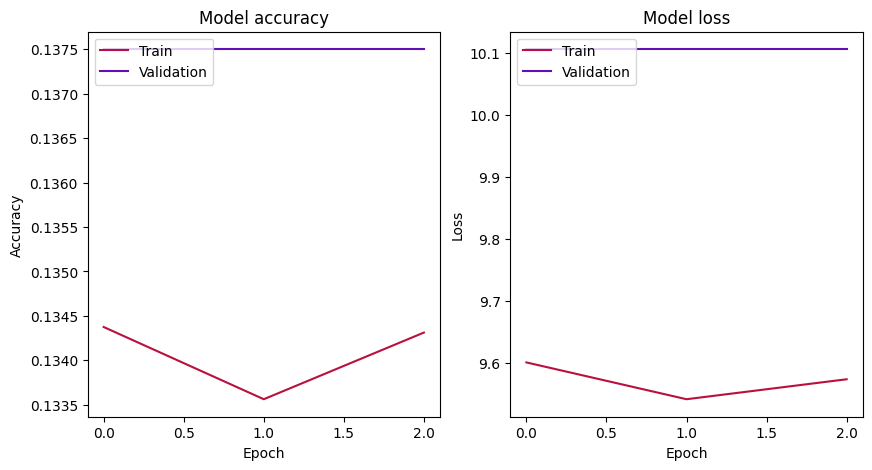

In [23]:
plot_learning_curve(history)

63/63 [==============================] - 9s 136ms/step
Shape of y_pred: (2000,)
Classification Report:
              precision    recall  f1-score   support

           0       0.14      1.00      0.24       275
           1       1.00      0.00      0.00       224
           2       1.00      0.00      0.00       695
           3       1.00      0.00      0.00       159
           4       1.00      0.00      0.00       581
           5       1.00      0.00      0.00        66

    accuracy                           0.14      2000
   macro avg       0.86      0.17      0.04      2000
weighted avg       0.88      0.14      0.03      2000



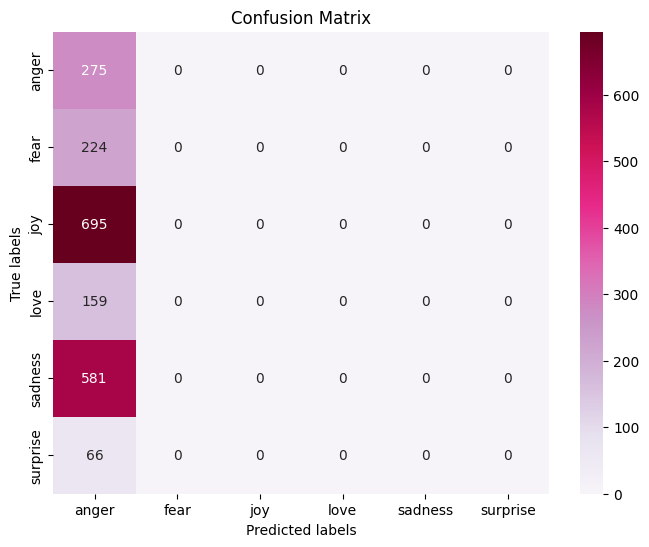

In [35]:
y_test = np.array([label for _, label in test_ds.unbatch()])

pred_logits = model.predict(test_ds).logits
y_pred = tf.argmax(pred_logits, axis=1).numpy()

y_test_int = np.argmax(y_test, axis=1)

print("Shape of y_pred:", y_pred.shape)

if len(y_pred.shape) == 1:
    y_pred_int = y_pred
else:
    y_pred_int = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test_int, y_pred_int, zero_division=1))

plot_confusion_matrix(y_test_int, y_pred_int)

In [26]:
train_time = start_time - end_time

print("Fine-tuning time of the model: {:.2f} seconds".format(-train_time))

Fine-tuning time of the model: 655.24 seconds
